In [2]:
import numpy as np

In [3]:
class Cell:
    def __init__(self,h=0,d=0,b=0,g=0):
        self.h, self.d, self.b, self.g = h, d, b, g
        self.visited = False
        self.neighbors = []
        self.xy = 0, 0

    def __repr__(self):
        return f"Cell(h={self.h}, b={self.b}, g={self.g}, d={self.d})"

In [4]:
class PseudoMaze:
    def __init__(self, size=None, grid=None, adj=None):
        args_given = (size != None) + (grid is not None) + (adj != None)
        if not args_given: raise ValueError("aucun argument n'a été donné permettant de construire un pseudo-labyrinthe")
        if args_given > 1:
            raise ValueError("impossible de choisir entre deux méthodes de construction")

        if size != None: # Méthode de construction : PL vide d'une taille donnée
            self.size = size
            self.height, self.width = self.size
        
            L = np.empty(self.size, dtype=Cell)
            for i in range(self.height):
                for j in range(self.width):
                    L[i,j] = Cell()
            for i in range(self.height):
                for j in range(self.width):
                    L[i, j].xy = j, i
                    if i == 0:
                        L[i, j].h = 1
                    if i == self.height - 1:
                        L[i, j].b = 1
                    if j == 0:
                        L[i, j].g = 1
                    if j == self.width - 1:
                        L[i, j].d = 1
            self.mazeMatrix = L
            self.__init__(grid=self.mazeMatrix)

        elif grid is not None: # Méthode de construction : murs
            self.size = grid.shape
            self.height, self.width = self.size

            for i in range(self.height):
                for j in range(self.width):
                    c = grid[i, j]
                    grid[i, j].xy = j, i
                    if i == 0 and not c.h: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if j == 0 and not c.g: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if i == self.height - 1 and not c.b: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if j == self.width - 1 and not c.d: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")

                    if not c.h: grid[i, j].neighbors.append(grid[i-1, j])
                    if not c.b: grid[i, j].neighbors.append(grid[i+1, j])
                    if not c.g: grid[i, j].neighbors.append(grid[i, j-1])
                    if not c.d: grid[i, j].neighbors.append(grid[i, j+1])

            self.mazeMatrix = grid
            attrs = {'d': (1, 0), 'g': (-1, 0), 'h': (0, -1), 'b': (0, 1)}
            self.adj = { # Probablement la pire compréhension Python que j'ai jamais écrite.
                (x, y): [
                    (xn, yn) for dir_ in attrs if not self.mazeMatrix[y, x].__getattribute__(dir_) \
                    and (0 <= (xn := x + (xyn := attrs[dir_])[0]) < self.width) and (0 <= (yn := y + xyn[1]) < self.height)
                ] for y, x in np.ndindex(self.size)
            }
            # On ajoute un graphe Sage, qui nous permettra d'utiliser directement certaines fonctions très utiles de Sage
            self.sage_graph = Graph(self.adj)
            

        else: # Méthode de construction : liste d'adjacence
            self.adj = adj
            attrs = {(1, 0): 'd', (-1, 0): 'g', (0, -1): 'h', (0, 1): 'b'}
            
            self.width = max(adj, key=lambda xy: xy[0])[0] + 1
            self.height = max(adj, key=lambda xy: xy[1])[1] + 1
            self.size = self.height, self.width

            self.mazeMatrix = np.array([[Cell(1, 1, 1, 1) for _ in range(self.width)] for _ in range(self.height)])
            for x, y in adj:
                for xn, yn in adj[(x, y)]:
                    if abs(x - xn) + abs(y - yn) != 1 or not (0 <= xn < self.width) or not (0 <= yn < self.height):
                        raise ValueError("la liste d'adjacence donnée ne correspond pas à un pseudo-labyrinthe valide")
                    self.mazeMatrix[y, x].__setattr__(attrs[(xn - x, yn - y)], 0)
            
            PseudoMaze(grid=self.mazeMatrix) # on vérifie que les murs sont bien formés


    def update(self):
        """
        Met à jour les attributs du PL à partir de ses murs.
        Utile quand l'on a modifié ladite matrice et que l'on souhaite éviter les incohérences avec les autres constructions.
        """
        for x, y in np.ndindex(self.size): self.mazeMatrix[x, y].neighbors = []
        self.__init__(grid=self.mazeMatrix)

    def est_labyrinthe(self):
        return self.sage_graph.is_tree()
    
    def plot_maze(self):
        p = plot([])
        for i in range(self.height):
            for j in range(self.width):
                y = self.height - i
                c = self.mazeMatrix[i, j]
                p += line2d([(j, y), (j, y-1)], thickness=1+4*c.g, color="black")
                p += line2d([(j, y), (j+1, y)], thickness=1+4*c.h, color="black")
                p += line2d([(j, y-1), (j+1, y-1)], thickness=1+4*c.b, color="black")
                p += line2d([(j+1, y), (j+1, y-1)], thickness=1+4*c.d, color="black")
        p.show()


In [5]:
def generation_aleatoire(width, height):
    # On initialise un PL rempli de murs
    L = PseudoMaze((width, height))
    for x, y in np.ndindex(L.size): (c := L.mazeMatrix[x, y]).h, c.g, c.d, c.b = 1, 1, 1, 1
    
    # On commence sur une cellule aléatoire
    currentCell = L.mazeMatrix[randint(0, width-1), randint(0, height-1)]
    currentCell.visited = True
    stack = [currentCell]

    # Tant que la pile n'est pas vide, ce qui équivaut à dire que l'on n'a pas tout visité
    while stack:
        # On prend la dernière cellule de la pile
        # et on détermine lesquels de ses voisins on n'a pas encore visité
        currentCell = stack[-1]
        non_visited_neighbors = [
            neighbor for neighbor in currentCell.neighbors if not neighbor.visited
        ]

        # Si la cellule a des voisins non visités, on continue de tracer un chemin avec celle-ci
        if non_visited_neighbors:
            # On choisit au hasard un voisin que l'on n'a pas encore vu
            nextCell = choice(non_visited_neighbors)
            nextCell.visited = True

            # Remove the wall between currentCell and nextCell
            (xc, yc), (xn, yn) = currentCell.xy, nextCell.xy
            if yc == yn:
                # On est sur la méme ligne, donc on enlève un mur vertical
                if xc < xn:
                    currentCell.d = 0
                    nextCell.g = 0
                else:
                    currentCell.g = 0
                    nextCell.d = 0
            else:
                # On est sur la mếme colonne, donc on enlève un mur horizontal
                if yc < yn:
                    currentCell.b = 0
                    nextCell.h = 0
                else:
                    currentCell.h = 0
                    nextCell.b = 0

            stack.append(nextCell)
        else:
            # Sinon, on revient en arrière, jusqu'à trouver une cellule ayant des voisins non visités
            # ou jusqu'à épuiser la pile, auquel cas le labyrinthe est terminé.
            stack.pop()
    
    L.update() # on met à jour l'attribut de construction par graphe

    return L

In [18]:
def nombre_labyrinthes(width, height):
    return abs(PseudoMaze((width, height)).sage_graph.laplacian_matrix()[1:, 1:].determinant())

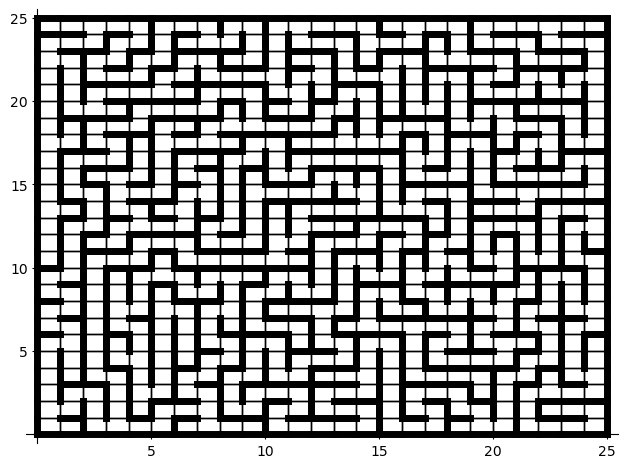

In [19]:
L = generation_aleatoire(25, 25)
L.plot_maze()

In [20]:
nombre_labyrinthes(5, 5)

557568000